In [2]:
import pandas as pd
import scipy.io
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

# Creating the Like DF

In [3]:
path = "../data/behavioralRatings.mat"
with h5py.File(path, "r") as f:
    print("HDF5 keys:", list(f.keys()))

HDF5 keys: ['behavioralRatings']


In [4]:
with h5py.File(path, "r") as f:
    br = f["behavioralRatings"]
    print("Type:", type(br))
    print("Shape:", br.shape)
    print("Dtype:", br.dtype)

Type: <class 'h5py._hl.dataset.Dataset'>
Shape: (2, 10, 20)
Dtype: float64


In [5]:
with h5py.File(path, "r") as f:
    br = f["behavioralRatings"][:]   # turn into NumPy array, shape (2, 10, 20)

In [6]:
# (2, 10, 20) to (20, 10, 2) in order to turn into same structure as matlab 
ratings = np.transpose(br, (2, 1, 0))

print(ratings.shape)

(20, 10, 2)


In [7]:
enjoyment = ratings[:, :, 1] 

In [8]:
participants = np.arange(1, 21)
songs = np.arange(1, 11)

like_df = pd.DataFrame(enjoyment,
                      index=participants,
                      columns=[f"song_{s}" for s in songs]).rename_axis("subject").reset_index()

like_df

,subject,song_1,song_2,song_3,song_4,song_5,song_6,song_7,song_8,song_9,song_10
0,1,8.0,8.0,5.0,5.0,9.0,7.0,6.0,7.0,5.0,5.0
1,2,8.0,8.0,7.0,5.0,3.0,7.0,5.0,5.0,4.0,4.0
2,3,8.0,7.0,8.0,6.0,8.0,7.0,7.0,8.0,7.0,6.0
3,4,8.0,7.0,2.0,7.0,9.0,6.0,7.0,7.0,5.0,7.0
4,5,6.0,8.0,6.0,5.0,7.0,7.0,8.0,7.0,7.0,3.0
5,6,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0,1.0
6,7,6.0,2.0,2.0,5.0,3.0,7.0,3.0,5.0,3.0,2.0
7,8,5.0,8.0,3.0,7.0,5.0,6.0,6.0,6.0,7.0,4.0
8,9,7.0,5.0,6.0,5.0,6.0,5.0,4.0,6.0,3.0,2.0
9,10,5.0,4.0,2.0,7.0,5.0,6.0,4.0,7.0,3.0,1.0


# Feature Creation

In [9]:
# Basically mapping freq to names/categories
BANDS = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 12),
    "beta": (12, 30),
    "gamma_low": (30, 45),
}

In [10]:
def calculate_bandpower(f, psd, fmin, fmax):
    idx = (f >= fmin) & (f <= fmax)
    return np.trapezoid(psd[idx], f[idx])

# Loading in Cleaned EEG data

In [11]:
np.random.seed(42)

In [12]:
all_X = []
all_y = []
participant_ids = []
song_ids = []

# they had weird mappings in the study, these numbers correspond to file names
# looping through each song
for song in range(21, 31):
    # loads in the file
    load_mat_file = loadmat(f"../data/cleaned_eeg/song{song}_Imputed.mat")
    # gets the current song
    data = load_mat_file[f"data{song}"]

    fs = float(load_mat_file["fs"].squeeze())

    channels, time, participants = data.shape

    # converting werid mappings to start at 1
    song_idx = song - 20
    song_label = like_df[f"song_{song_idx}"].to_numpy()

    # loop through each participant
    for participant in range(participants):
        # get eeg data for given participant for the given song
        eeg_participant = data[:, :, participant]

        # this chunk just gets the band power for each participant for given song
        feature_list = []
        for channel in range(channels):
            f, psd = welch(eeg_participant[channel, :], fs = fs, nperseg = 2 * int(fs))
            for fmin, fmax in BANDS.values():
                band_power = calculate_bandpower(f, psd, fmin, fmax)
                feature_list.append(band_power)

        feature_vec = np.log10(np.array(feature_list) + .000000000000000000001)
        all_X.append(feature_vec)

        # basically liked if score above 6, no like below 6
        all_y.append(1 if song_label[participant] >= 6 else 0)
        participant_ids.append(participant)
        song_ids.append(song_idx)

# Convert to usable format
X_all = np.vstack(all_X)
y_all = np.array(all_y)

participant_ids = np.array(participant_ids)
song_ids = np.array(song_ids)


In [13]:
scaler = StandardScaler()
logo = LeaveOneGroupOut()
X_scaled = scaler.fit_transform(X_all)
logo

LeaveOneGroupOut()

In [26]:
random_model = DummyClassifier(strategy="uniform", random_state=42)

## Metrics for Random Model


In [27]:
accuracies = []
precisions = []
recalls = []
# conf_matrix_folds = []

# collecting across all folds bc my prec recall kinda weird with some classes having none per fold
all_folds_y_true = []
all_folds_y_pred = []

for train_idx, test_idx in logo.split(X_scaled, y_all, participant_ids):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    random_model.fit(X_train, y_train)
    y_pred = random_model.predict(X_test)
    y_prob = random_model.predict_proba(X_test)[:, 1]

    accuracies.append(accuracy_score(y_test, y_pred))

    all_folds_y_true.extend(y_test)
    all_folds_y_pred.extend(y_pred)

    # cm = confusion_matrix(y_test, y_pred, labels = [0,1])
    # conf_matrix_folds.append(cm)
    
    # precisions.append(precision_score(y_test, y_pred, pos_label=1, zero_division = 0))
    # recalls.append(recall_score(y_test, y_pred, pos_label = 1, zero_division=0))

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        labels = [0,1],
        average = None,
        zero_division = 0
    )

    precisions.append(prec)
    recalls.append(rec)

all_folds_y_true = np.array(all_folds_y_true)
all_folds_y_pred = np.array(all_folds_y_pred)

prec, rec, f1, support = precision_recall_fscore_support(
    all_folds_y_true,
    all_folds_y_pred,
    labels = [0,1],
    average = None,
    zero_division = 0
)

# print("Precision across all folds: ", np.mean(precisions))
# print("Recall across all folds: ", np.mean(recalls))

precisions = np.array(precisions)
recalls = np.array(recalls)

mean_prec_class0, mean_prec_class1 = precisions.mean(axis = 0)
mean_recall_class0, mean_recall_class1 = recalls.mean(axis = 0)

print("Metrics from aggregation across folds")
print("Acurracy across all folds: ", np.mean(accuracies))

print("Precision for Class 0: ", mean_prec_class0)
print("Precision for Class 1: ", mean_prec_class1)

print("Recall for Class 0: ", mean_recall_class0)
print("Recall for Class 1: ", mean_recall_class1)

print("------------------------------------")
print("Computing Precision Recall whole data set (not per fold)")

print("Precision for class 0: ", prec[0])
print("Precision for class 1: ", prec[1])

print("Recall for class 0: ", rec[0])
print("Recall for class 1: ", rec[1])

Metrics from aggregation across folds
Acurracy across all folds:  0.46499999999999997
Precision for Class 0:  0.44285714285714295
Precision for Class 1:  0.5166666666666665
Recall for Class 0:  0.6335119047619047
Recall for Class 1:  0.26688492063492064
------------------------------------
Computing Precision Recall whole data set (not per fold)
Precision for class 0:  0.44285714285714284
Precision for class 1:  0.5166666666666667
Recall for class 0:  0.6813186813186813
Recall for class 1:  0.28440366972477066


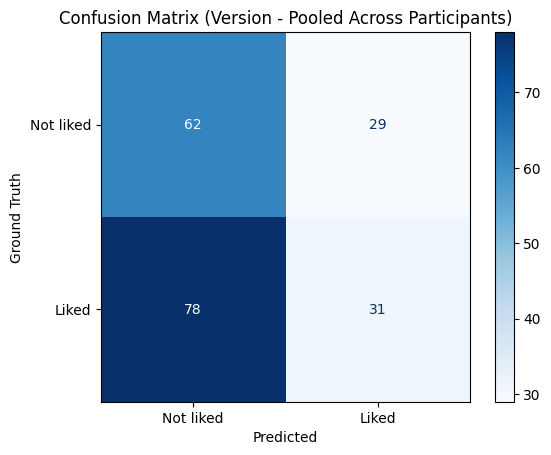

In [28]:
conf_matrix = confusion_matrix(all_folds_y_true, all_folds_y_pred, labels = [0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix = conf_matrix,
    display_labels = ["Not liked", "Liked"]
)

disp.plot(cmap="Blues", values_format = ".0f")
plt.title("Confusion Matrix (Version - Pooled Across Participants)")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()